In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

from utils import eval_model
from itertools import chain

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [106]:
df_aluminium = pd.read_csv('dataset/' + '2005-2022-aluminium.csv')
df_copper = pd.read_csv('dataset/' + '2005-2022-copper.csv')
df_iron = pd.read_csv('dataset/' + '2010-2022-iron.csv')
df_palladium = pd.read_csv('dataset/' + '2005-2022-palladium.csv')
df_zinc = pd.read_csv('dataset/' + '2005-2022-zinc.csv')
df_lead = pd.read_csv('dataset/' + '2005-2022-lead.csv')
df_nickel = pd.read_csv('dataset/' + '2005-2022-nickel.csv')
df_platinum = pd.read_csv('dataset/' + '2005-2022-platinum_nymex.csv')
df_rhodium = pd.read_csv('dataset/' + '2005-2022-rhodium.csv')
df_tin = pd.read_csv('dataset/' + '2005-2022-tin.csv')
df_palladium_lbma = pd.read_csv('dataset/' + '2005-2022-palladium_lbma.csv')
df_platinum_lbma = pd.read_csv('dataset/' + '2005-2022-platinum_lbma.csv')
df_cobalt = pd.read_csv('dataset/' + '2010-2022-cobalt.csv')
df_rebar = pd.read_csv('dataset/' + '2009-2022-rebar_shfe.csv')
df_silver = pd.read_csv('dataset/' + '2005-2022-silver.csv')

dataset_all = [df_aluminium, df_copper, df_iron, df_palladium, df_zinc, df_lead, df_nickel, df_platinum, df_tin, df_palladium_lbma, df_platinum_lbma,df_rebar, df_silver]
name_all = ['aluminium', 'copper', 'iron' ,'palladium', 'zinc', 'lead', 'nickel', 'platinum', 'tin', 'palladium_lbma', 'platinum_lbma','rebar', 'silver']


common_cols = set.intersection(*map(set,dataset_all))

for df in dataset_all:
    df.drop(df.columns.difference(common_cols), axis=1, inplace=True)
    if df.columns[0] != 'date' or df.columns[-1] !='y':
        print('something wrong')
    
print('data cleaned')

data cleaned


## Linear Regression

### backtest and store evaluation metrics

In [93]:
def PCRBacktest(df, lookback_month, horizon_month):
    train_size = 22 * lookback_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        test_df = df[train_size + skip_size:train_size + skip_size + test_size]
        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values

        print('X_train:{}, y_train:{}, X_test:{}, y_test{}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
        
        scaler = StandardScaler()
        pca = PCA(n_components=5)
        
        X_train_transformed = scaler.fit_transform(X_train)
        X_train_transformed_pca = pca.fit_transform(X_train_transformed)
        # Linear Regression model
        regressor = LinearRegression()  
        regressor.fit(X_train_transformed_pca, y_train)
        
        X_test_transformed = scaler.transform(X_test)
        X_test_transformed_pca = pca.transform(X_test_transformed)
        
        # make prediction
        y_pred = regressor.predict(X_test_transformed_pca)

        # append result to the list 
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)

        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2019-05-01']['pred']
    y_test = df_res[df_res.date >= '2019-05-01']['test']
    print(len(y_test))
    return y_test, y_pred

In [88]:
def PLSBacktest(df, lookback_month, horizon_month, pls_components=5):
    train_size = 22 * lookback_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        test_df = df[train_size + skip_size:train_size + skip_size + test_size]
        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values

        print('X_train:{}, y_train:{}, X_test:{}, y_test{}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
        
        # Linear Regression model
        regressor = PLSRegression(n_components=pls_components)
        regressor.fit(X_train, y_train)
        
        # make prediction
        y_pred = regressor.predict(X_test)

        # append result to the list 
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)

        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2019-05-01']['pred']
    y_test = df_res[df_res.date >= '2019-05-01']['test']

    return y_test, y_pred

In [61]:
def LinearRegressionBacktestValid(df, lookback_month, horizon_month):
    train_size = 22 * lookback_month
    val_size = 22 * horizon_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        val_df = df[train_size + skip_size:train_size + skip_size + val_size]
        test_df = df[train_size + skip_size + val_size + skip_size: train_size + skip_size + val_size + skip_size + test_size]

        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns != 'y')].values
        y_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values
        
        print('train_index: {}-{}, val_index: {}-{}, test_index: {}-{}'.format(offset,train_size, train_size + skip_size,train_size + skip_size + val_size, train_size + skip_size + val_size + skip_size,train_size + skip_size + val_size + skip_size + test_size ))
        

        best_mse = 1e9
        for i in [1,2,3,5,7,10]:
            
            scaler = StandardScaler()
            pca = PCA(n_components=i)
            
            X_train_transformed = scaler.fit_transform(X_train)
            X_train_transformed_pca = pca.fit_transform(X_train_transformed)
            
            regressor = LinearRegression()
            regressor.fit(X_train_transformed_pca, y_train)

            X_val_transformed = scaler.transform(X_val)
            X_val_transformed_pca = pca.transform(X_val_transformed)
            
            # make prediction
            y_pred = regressor.predict(X_val_transformed_pca)
            _, mse, _, _ = eval_model(y_pred.flatten(), y_val.flatten())
            
            if mse < best_mse:
                best_mse = mse
                best_grid = i
        
        scaler = StandardScaler()
        pca = PCA(n_components=best_grid)
            
        X_train_transformed = scaler.fit_transform(X_train)
        X_train_transformed_pca = pca.fit_transform(X_train_transformed)
            
        regressor.fit(X_train_transformed_pca, y_train)

        X_test_transformed = scaler.transform(X_test)
        X_test_transformed_pca = pca.transform(X_test_transformed)
                

        # make prediction
        y_pred = regressor.predict(X_test_transformed_pca)

        # append result to the list 
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)

        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2019-05-01']['pred']
    y_test = df_res[df_res.date >= '2019-05-01']['test']
    print(len(y_test))
    return y_test, y_pred

In [62]:
def PLSBacktestValid(df, lookback_month, horizon_month, pls_components=5):
    train_size = 22 * lookback_month
    val_size = 22 * horizon_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        val_df = df[train_size + skip_size:train_size + skip_size + val_size]
        test_df = df[train_size + skip_size + val_size + skip_size: train_size + skip_size + val_size + skip_size + test_size]

        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns != 'y')].values
        y_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values
        
        print('train_index: {}-{}, val_index: {}-{}, test_index: {}-{}'.format(offset,train_size, train_size + skip_size,train_size + skip_size + val_size, train_size + skip_size + val_size + skip_size,train_size + skip_size + val_size + skip_size + test_size ))
        
        
        grid = { 'n_components': [1,2,3,4,5]}
        best_mse = 1e9
        
        for g in ParameterGrid(grid):
        
            # Linear Regression model
            regressor = PLSRegression()
            regressor.set_params(**g)  
            regressor.fit(X_train, y_train)

            y_pred = regressor.predict(X_val)
            _, mse, _, _ = eval_model(y_pred.flatten(), y_val.flatten())
            
            if mse < best_mse:
                best_mse = mse
                best_grid = g
        print(best_grid)
        regressor.set_params(**best_grid)  
        regressor.fit(X_train, y_train)
        
        # make prediction
        y_pred = regressor.predict(X_test)

        # append result to the list 
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)

        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2019-05-01']['pred']
    y_test = df_res[df_res.date >= '2019-05-01']['test']

    return y_test, y_pred

In [94]:
def LinearRegressionBacktest(df, lookback_month, horizon_month):
    train_size = 22 * lookback_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        test_df = df[train_size + skip_size:train_size + skip_size + test_size]
        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values

        print('X_train:{}, y_train:{}, X_test:{}, y_test{}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
        
        scaler = StandardScaler()
        
        X_train_transformed = scaler.fit_transform(X_train)
        # Linear Regression model
        regressor = LinearRegression()  
        regressor.fit(X_train_transformed, y_train)
        
        X_test_transformed = scaler.transform(X_test)
        
        # make prediction
        y_pred = regressor.predict(X_test_transformed)

        # append result to the list 
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)

        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2019-05-01']['pred']
    y_test = df_res[df_res.date >= '2019-05-01']['test']
    print(len(y_test))
    return y_test, y_pred

In [102]:
for name, df in zip(name_all, dataset_all):
    print(name)
    eval_metrics = {'lookback': [], 'horizon': [], 'accuracy': [], 'mse':[], 'r_square':[], 'pcc': []}

    for i in range(12, 132, 6):
        y_test, y_pred  = PCRBacktest(df, i, 6)
        
        acc, mse, r_square, pcc = eval_model(y_test, y_pred)

        eval_metrics['lookback'].append(i)
        eval_metrics['horizon'].append(j)
        eval_metrics['accuracy'].append(acc)
        eval_metrics['mse'].append(mse)
        eval_metrics['r_square'].append(r_square)
        eval_metrics['pcc'].append(pcc)
            
    df_metric = pd.DataFrame(eval_metrics)
    df_metric.to_csv('Outputs/ML-model/PCR/PCR-{}.csv'.format(name))

aluminium
X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 1)

X_train:(264, 11), y_train:(264, 1), X_test:(132, 11), y_test(132, 

## ARIMA

In [109]:
def Backtest_ARIMA(start_date, end_date, test_start_date, df, window_size):
    # Split training set and test set by date
    timePass = df[(df.date >= start_date) & (df.date < end_date)].reset_index(drop=True)
    train = timePass[(timePass.date >= start_date) & (timePass.date < test_start_date)]
    test = timePass[(timePass.date >= test_start_date) & (timePass.date < end_date)]
    
    # Get y_test array
    y_test = test.loc[:, (test.columns != 'date') & (test.columns == 'y')].values
    print('Test set data points', len(y_test))
    
    # initialize some paras for looping the time range
    last_index = timePass.index[-1]
    y_pred = []
    fit_range = range(0,last_index - 22 * window_size + 1)
    
    for i in fit_range:
        # create training batch
        batch = timePass.iloc[i::22][:window_size]
        train_values = batch['y']

        # fit arima model
        model_arima = ARIMA(train_values, order=(2,0,1))

        model_arima = model_arima.fit()

        # make prediction and add to y_pred
        pred = model_arima.forecast(1)
        y_pred.append(pred.values[0])
        if i % 100 == 0: 
            print(i)
    y_pred = y_pred[-len(y_test):]
    y_pred = np.array(y_pred)
    eval_model(y_test.flatten(), y_pred)
    
    return y_pred, y_test.flatten()

In [110]:
dataset_all = [df_aluminium, df_copper, df_iron, df_palladium, df_zinc, df_lead, df_nickel, df_platinum, df_tin, df_palladium_lbma, df_platinum_lbma,df_rebar, df_silver]
name_all = ['aluminium', 'copper', 'iron' ,'palladium', 'zinc', 'lead', 'nickel', 'platinum', 'tin', 'palladium_lbma', 'platinum_lbma','rebar', 'silver']

In [113]:
start_date = pd.to_datetime('2005-05-01')
end_date = pd.to_datetime('2022-03-01')
test_start_date = pd.to_datetime('2019-05-01')
res_arima = []
for df in dataset_all:
    
    df_target = df[['date','y']]
    df_target['date'] = pd.to_datetime(df['date'])
    y_pred, y_test = Backtest_ARIMA(start_date, end_date, test_start_date, df_target, window_size=12)
    acc, mse,_, pcc = eval_model(y_pred,y_test)
    
    res_arima.append((acc,mse,pcc))

Test set data points 739
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
Test set data points 739
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
Test set data points 739
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
Test set data points 739
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
Test set data points 739
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


In [115]:
df_res = pd.DataFrame(data = {'ARIMA': res_arima}, index=name_all).T

In [120]:
df_res['silver'][0]

(0.41271989174560214, 0.01859600518409438, -0.35475232703884385)

In [117]:
df_res.to_csv('ARIMA.csv')

In [108]:
# initialize backtesting time range
start_date = pd.to_datetime('2005-05-01')
end_date = pd.to_datetime('2022-03-01')
test_start_date = pd.to_datetime('2019-05-01')
df_target = df[['date','y']]

y_pred, y_test = Backtest_ARIMA(start_date, end_date, test_start_date, df_target, window_size=12)
print(len(y_pred),len(y_test))

TypeError: '>=' not supported between instances of 'str' and 'Timestamp'

In [23]:
eval_model(y_pred,y_test)

(0.550744248985115,
 0.0036873580668270295,
 -26.37843795334506,
 -0.11562671876645042)

## XGBoost- Gradient boosting tree

In [5]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [6]:
def XGBoostBacktest(df, lookback_month, horizon_month): 
    train_size = 22 * lookback_month
    val_size = 22 * horizon_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        val_df = df[train_size + skip_size:train_size + skip_size + val_size]
        test_df = df[train_size + skip_size + val_size + skip_size: train_size + skip_size + val_size + skip_size + test_size]

        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns != 'y')].values
        y_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values
        
        print('train_index: {}-{}, val_index: {}-{}, test_index: {}-{}'.format(offset,train_size, train_size + skip_size,train_size + skip_size + val_size, train_size + skip_size + val_size + skip_size,train_size + skip_size + val_size + skip_size + test_size ))
        
        grid = { 'max_depth': [3,6,10],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 500, 1000],
                'colsample_bytree': [0.3, 0.7]}
        best_mse = 1e9
        for g in ParameterGrid(grid):
            
            scaler = StandardScaler()
            # pca = PCA(n_components=5)
            
            X_train_transformed = scaler.fit_transform(X_train)
            # X_train_transformed_pca = pca.fit_transform(X_train_transformed)
            
            regressor = XGBRegressor()
            regressor.set_params(**g)  
            regressor.fit(X_train_transformed, y_train)

            X_val_transformed = scaler.transform(X_val)
            # X_val_transformed_pca = pca.transform(X_val_transformed)
            
            # make prediction
            y_pred = regressor.predict(X_val_transformed)
            _, mse, _, _ = eval_model(y_pred, y_val)
            
            if mse < best_mse:
                best_mse = mse
                best_grid = g
        regressor.set_params(**best_grid)  
        regressor.fit(X_train_transformed, y_train)

        X_test_transformed = scaler.transform(X_test)
        # X_test_transformed_pca = pca.transform(X_test_transformed)
                

        # make prediction
        y_pred = regressor.predict(X_test_transformed)
        print(eval_model(y_test.flatten(), y_pred.flatten()))
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)
        
        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2018-05-01']['pred']
    y_test = df_res[df_res.date >= '2018-05-01']['test']

    return y_pred,y_test


In [7]:
df = pd.read_csv('2005-2022-test.csv')
df['date'] = pd.to_datetime(df['date'])
y_pred,y_test = XGBoostBacktest(df, 96, 1)
plt.plot(y_pred)
plt.plot(y_test)

train_index: 0-2112, val_index: 2134-2156, test_index: 2178-2200


KeyboardInterrupt: 

In [11]:
eval_model(y_pred,y_test)

(0.6763236763236763,
 0.0028015467215990217,
 -2.9149217010154187,
 0.32109981902234697)

In [94]:
# train_index: 396-2904, val_index: 2926-2992, test_index: 3014-3080
train_df = df[396:2904]
val_df = df[2926:2992]
test_df = df[3014: 3080]


# Split the data to training set and test set
X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

X_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns != 'y')].values
y_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns == 'y')].values

X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
test_date = test_df['date'].values

# print('train_index: {}-{}, val_index: {}-{}, test_index: {}-{}'.format(offset,train_size, train_size + skip_size,train_size + skip_size + val_size, train_size + skip_size + val_size + skip_size,train_size + skip_size + val_size + skip_size + test_size ))

grid = { 'max_depth': [3,6,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
        'colsample_bytree': [0.3, 0.7]}
best_mse = 1e9
for g in ParameterGrid(grid):
        
        scaler = StandardScaler()
        pca = PCA(n_components=5)
        
        X_train_transformed = scaler.fit_transform(X_train)
        X_train_transformed_pca = pca.fit_transform(X_train_transformed)

        regressor = XGBRegressor()
        regressor.set_params(**g)  
        regressor.fit(X_train_transformed_pca, y_train)

        X_val_transformed = scaler.transform(X_val)
        X_val_transformed_pca = pca.transform(X_val_transformed)
        
        # make prediction
        y_pred = regressor.predict(X_val_transformed_pca)
        _, mse, _, _ = eval_model(y_pred, y_val)
        
        if mse < best_mse:
                best_mse = mse
                best_grid = g
regressor.set_params(**best_grid)  
regressor.fit(X_train_transformed_pca, y_train)

X_test_transformed = scaler.transform(X_test)
X_test_transformed_pca = pca.transform(X_test_transformed)
        

# make prediction
y_pred = regressor.predict(X_test_transformed_pca)
print(eval_model(y_test.flatten(), y_pred.flatten()))
y_pred_list.append(y_pred.flatten())
y_test_list.append(y_test.flatten())
test_date_list.append(test_date)

# offset += 22 * horizon_month
# train_size += 22 * horizon_month

# if y_test.shape[0] < test_size:
#         break

# y_pred_list = list(chain(*y_pred_list))
# y_test_list = list(chain(*y_test_list))
# test_date_list = list(chain(*test_date_list))

# df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

# y_pred = df_res[df_res.date >= '2018-05-01']['pred']
# y_test = df_res[df_res.date >= '2018-05-01']['test']

(0.803030303030303, 0.003164390459987957, -2.756760549479617, nan)


NameError: name 'y_pred_list' is not defined

## SVR

In [27]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [24]:
def SVRBacktest(df, lookback_month, horizon_month): 
    train_size = 22 * lookback_month
    val_size = 22 * horizon_month
    test_size = 22 * horizon_month
    skip_size = 22 * 1
    offset = 0
    y_pred_list = []
    y_test_list = []
    test_date_list = []

    while offset <= len(df):
        train_df = df[offset:train_size]
        val_df = df[train_size + skip_size:train_size + skip_size + val_size]
        test_df = df[train_size + skip_size + val_size + skip_size: train_size + skip_size + val_size + skip_size + test_size]

        # Split the data to training set and test set
        X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
        y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

        X_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns != 'y')].values
        y_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns == 'y')].values

        X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
        y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
        test_date = test_df['date'].values
        
        print('train_index: {}-{}, val_index: {}-{}, test_index: {}-{}'.format(offset,train_size, train_size + skip_size,train_size + skip_size + val_size, train_size + skip_size + val_size + skip_size,train_size + skip_size + val_size + skip_size + test_size ))
        
        grid = {'C': [math.pow(2,-5), math.pow(2,-3), math.pow(2,-1), math.pow(2,1), math.pow(2,3), math.pow(2,5), math.pow(2,7)], 
                'gamma': [math.pow(2,-11), math.pow(2,-9), math.pow(2,-7), math.pow(2,-5), math.pow(2,-3), math.pow(2,-1), math.pow(2,1), math.pow(2,3), math.pow(2,5)],
                'epsilon': [math.pow(2,-5), math.pow(2,-4), math.pow(2,-3), math.pow(2,-2), math.pow(2,-1)],
                'kernel': ['rbf']}
        
        best_mse = 1e9
        for g in ParameterGrid(grid):
            
            scaler = StandardScaler()
            pca = PCA(n_components=5)
            
            # X_train_transformed = scaler.fit_transform(X_train)
            # X_train_transformed_pca = pca.fit_transform(X_train_transformed)
            
            regressor = SVR()
            regressor.set_params(**g)  
            regressor.fit(X_train, y_train)

            # X_val_transformed = scaler.transform(X_val)
            # X_val_transformed_pca = pca.transform(X_val_transformed)
            
            # make prediction
            y_pred = regressor.predict(X_val)
            _, mse, _, _ = eval_model(y_pred, y_val)
            
            if mse < best_mse:
                best_mse = mse
                best_grid = g
        regressor.set_params(**best_grid)  
        # print(best_grid)
        regressor.fit(X_train, y_train)

        # X_test_transformed = scaler.transform(X_test)
        # X_test_transformed_pca = pca.transform(X_test_transformed)
                

        # make prediction
        y_pred = regressor.predict(X_test)
        print(eval_model(y_test.flatten(), y_pred.flatten()))
        y_pred_list.append(y_pred.flatten())
        y_test_list.append(y_test.flatten())
        test_date_list.append(test_date)
        
        offset += 22 * horizon_month
        train_size += 22 * horizon_month

        if y_test.shape[0] < test_size:
            break

    y_pred_list = list(chain(*y_pred_list))
    y_test_list = list(chain(*y_test_list))
    test_date_list = list(chain(*test_date_list))

    df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

    y_pred = df_res[df_res.date >= '2018-05-01']['pred']
    y_test = df_res[df_res.date >= '2018-05-01']['test']

    return y_pred,y_test


In [36]:
df = pd.read_csv('2005-2022-test.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(['FeatureFamily.MACRO.1'], axis=1)
# y_pred,y_test = SVRBacktest(df, 114, 24)
# plt.plot(y_pred)
# plt.plot(y_test)

In [37]:
y_pred,y_test = SVRBacktest(df, 114, 12)
eval_model(y_pred,y_test)

train_index: 0-2508, val_index: 2530-2794, test_index: 2816-3080
(0.35984848484848486, 0.002841161376555672, -0.47639939711381163, -0.1869006825466899)
train_index: 264-2772, val_index: 2794-3058, test_index: 3080-3344
(0.4583333333333333, 0.002698147562293941, -0.6446267296187913, -0.2736280880413043)
train_index: 528-3036, val_index: 3058-3322, test_index: 3344-3608
(0.6742424242424242, 0.003058423523686953, 0.05840992758445829, 0.3732007191909241)
train_index: 792-3300, val_index: 3322-3586, test_index: 3608-3872
(0.625, 0.001072064154597898, 0.006795339195318717, 0.16911514616323986)
train_index: 1056-3564, val_index: 3586-3850, test_index: 3872-4136
(0.7272727272727273, 0.0025462245301698266, 0.07122010106816135, 0.3191466481906836)
train_index: 1320-3828, val_index: 3850-4114, test_index: 4136-4400
(0.7984496124031008, 0.004385663684960429, -0.06859344856588234, -0.08586532190275928)


(0.7112887112887113,
 0.00237183927477361,
 -2.084873595331092,
 0.44846706655142354)

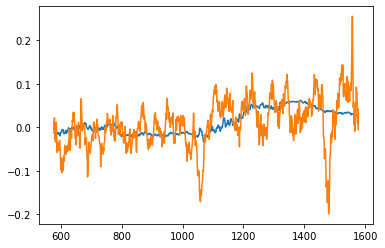

In [38]:
plt.plot(y_pred)
plt.plot(y_test)

In [29]:
eval_metrics = {'lookback': [], 'horizon': [], 'accuracy': [], 'mse':[], 'r_square':[], 'pcc': []}

for i in range(12, 132, 6):
    for j in [1,3,6,9,12,15,18,21,24]:
        
        y_pred,y_test = SVRBacktest(df, i, j)
        acc, mse, r_square, pcc  = eval_model(y_pred,y_test)
        
        eval_metrics['lookback'].append(i)
        eval_metrics['horizon'].append(j)
        eval_metrics['accuracy'].append(acc)
        eval_metrics['mse'].append(mse)
        eval_metrics['r_square'].append(r_square)
        eval_metrics['pcc'].append(pcc)
        
df_metric = pd.DataFrame(eval_metrics)
df_metric.to_csv('Outputs/ML-model/SVR-allhorizon.csv')

train_index: 0-264, val_index: 286-308, test_index: 330-352
(0.6818181818181818, 0.0008635571920069668, -0.5706235379884528, 0.10113940089436993)
train_index: 22-286, val_index: 308-330, test_index: 352-374
(0.22727272727272727, 0.009679781881478923, -3.5919464241036883, nan)
train_index: 44-308, val_index: 330-352, test_index: 374-396
(0.45454545454545453, 0.002613580994662466, -0.000900397476719661, -0.17468844230170902)
train_index: 66-330, val_index: 352-374, test_index: 396-418
(0.7272727272727273, 0.002848813615265601, -2.671355268646621, -0.03574057035417069)
train_index: 88-352, val_index: 374-396, test_index: 418-440
(0.6363636363636364, 0.0005795274084868386, 0.24517432772184766, 0.692458573565899)
train_index: 110-374, val_index: 396-418, test_index: 440-462
(0.6363636363636364, 0.0019569912951024897, -0.8573997061424801, 0.19342708352021543)
train_index: 132-396, val_index: 418-440, test_index: 462-484
(0.22727272727272727, 0.002175815302413725, -1.1055232025802453, 0.27834

In [30]:
df_metric

,lookback,horizon,accuracy,mse,r_square,pcc
0,12,1,0.518482,0.004144,-1.933621,0.054781
1,12,3,0.500500,0.004123,-3.830642,-0.096328
2,12,6,0.580420,0.003000,-5.891988,0.167594
3,12,9,0.496503,0.003320,-12.400771,-0.075320
4,12,12,0.598402,0.003139,-8.731233,0.072947
...,...,...,...,...,...,...
175,126,12,0.708292,0.002482,-4.953280,0.411594
176,126,15,0.499500,0.002955,-22.686470,0.122556
177,126,18,0.605395,0.002652,-3.531341,0.423021
178,126,21,0.442557,0.003315,-5.378643,0.089735


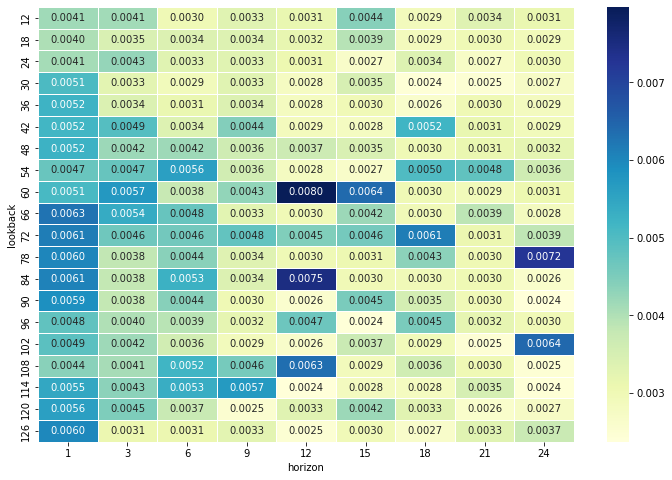

In [34]:
df = df_metric[['lookback','horizon','mse']]

df = df.pivot("lookback", "horizon", "mse")
ax = plt.figure(figsize=(12,8))
ax = sns.heatmap(df, annot=True, fmt=".4f", linewidths=.5, cmap="YlGnBu")
plt.show()

In [ ]:
train_index: 858-1122, val_index: 1144-1166, test_index: 1188-1210

In [7]:
train_df = df[858:1122]
val_df = df[1144 :1166]
test_df = df[1188: 1210]

# Split the data to training set and test set
X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

X_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns != 'y')].values
y_val = val_df.loc[:, (val_df.columns != 'date') & (val_df.columns == 'y')].values

X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
test_date = test_df['date'].values

# print('train_index: {}-{}, val_index: {}-{}, test_index: {}-{}'.format(offset,train_size, train_size + skip_size,train_size + skip_size + val_size, train_size + skip_size + val_size + skip_size,train_size + skip_size + val_size + skip_size + test_size ))


In [10]:

grid = {'C': [0.1,1, 10, 100], 
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf','linear']}

best_mse = 1e9
for g in ParameterGrid(grid):
    print(g)
    scaler = StandardScaler()
    pca = PCA(n_components=5)

    X_train_transformed = scaler.fit_transform(X_train)
    X_train_transformed_pca = pca.fit_transform(X_train_transformed)

    regressor = SVR()
    regressor.set_params(**g)  
    regressor.fit(X_train_transformed_pca, y_train)

    X_val_transformed = scaler.transform(X_val)
    X_val_transformed_pca = pca.transform(X_val_transformed)

    # make prediction
    y_pred = regressor.predict(X_val_transformed_pca)
    _, mse, _, _ = eval_model(y_pred, y_val)
    
    if mse < best_mse:
        best_mse = mse
        best_grid = g
regressor.set_params(**best_grid)  
regressor.fit(X_train_transformed_pca, y_train)

X_test_transformed = scaler.transform(X_test)
X_test_transformed_pca = pca.transform(X_test_transformed)


# make prediction
y_pred = regressor.predict(X_test_transformed_pca)
print(eval_model(y_test.flatten(), y_pred.flatten()))

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
{'C': 1, 'gamma': 1, 'kernel': 'linear'}
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
{'C': 10, 'gamma': 1, 'kernel': 'linear'}
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0

In [ ]:
df_metric = pd.DataFrame(eval_metrics)

In [ ]:
df_metric

In [57]:
train_size = 22 * 48
test_size = 22
skip_size = 22
offset = 0
y_pred_list = []
y_test_list = []
test_date_list = []

while offset <= len(df):
    train_df = df[offset:train_size]
    test_df = df[train_size + skip_size:train_size + skip_size + test_size]
    # Split the data to training set and test set
    X_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns != 'y')].values
    y_train = train_df.loc[:, (train_df.columns != 'date') & (train_df.columns == 'y')].values

    X_test  = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns != 'y')].values
    y_test = test_df.loc[:, (test_df.columns != 'date') & (test_df.columns == 'y')].values
    test_date = test_df['date'].values
    print('X_train:{}, y_train:{}, X_test:{}, y_test{}\n'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    
    # Linear Regression model
    regressor = SVR(gamma='auto', C = 10)
    regressor.fit(X_train, y_train)
    # make prediction
    y_pred = regressor.predict(X_test)
    
    # append result to the list 
    y_pred_list.append(y_pred.flatten())
    y_test_list.append(y_test.flatten())
    test_date_list.append(test_date)
    
    offset += 22
    train_size += 22
    
    if y_test.shape[0] < test_size:
        break

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_trai

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_train:(1056, 10), y_train:(1056, 1), X_test:(22, 10), y_test(22, 1)

X_trai

In [58]:
y_pred_list = list(chain(*y_pred_list))
y_test_list = list(chain(*y_test_list))
test_date_list = list(chain(*test_date_list))

df_res = pd.DataFrame({'date': test_date_list, 'test': y_test_list, 'pred': y_pred_list})

In [59]:
y_pred = df_res[df_res.date >= '2015-05-01']['pred']
y_test = df_res[df_res.date >= '2015-05-01']['test']

eval_model(y_test, y_pred)

(0.5243970835670219,
 0.0044700533516276765,
 -0.6186280438061096,
 0.07568215446581944)

<AxesSubplot:>

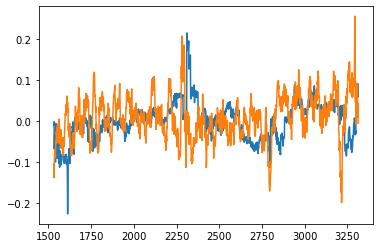

In [60]:
y_pred.plot()
y_test.plot()